In [1]:
from keras import backend as K 
K.clear_session()

In [2]:
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from tensorflow.keras.layers import SpatialDropout2D, Dense, Activation, Flatten, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D, Conv2D, BatchNormalization, MaxPooling2D, Input, Concatenate, ReLU, AveragePooling2D, UpSampling2D
# from tensorflow.keras.applications import DenseNet201, InceptionResNetV2, MobileNetV2, EfficientNetB3, Xception, VGG19, InceptionV3, EfficientNetB0, EfficientNetB2, Xception
from tensorflow.keras import regularizers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Model
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD, Adam
import numpy as np
import random
import shutil

In [3]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC,Precision,Recall

In [4]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
target = 256

# inject noise but keep dark parts black
# def addNoise(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
#     ret, mask = cv2.threshold(gray, 5, 255, cv2.THRESH_BINARY)

#     randStd = random.uniform(0, 10.0) # 15
#     gaussian = np.random.normal(randStd*-1, randStd, (target, target,3))
#     noisy_image = image + gaussian
#     image = np.clip(noisy_image, 0, 255).astype(np.uint8)

#     image[mask == 0] = [0,0,0]
#     image = preprocess_input(image)
#     return image

In [5]:
import cv2
import numpy as np

def preprocess_image(image):
    # Convert image to LAB color space
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    
    # Split the LAB image into channels
    l, a, b = cv2.split(lab)
    
    # Convert the L channel to the appropriate data type
    l = l.astype(np.uint8)  # or l = l.astype(np.uint16) for 16-bit images
    
    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    
    # Check if dimensions match
    if cl.shape[:2] != a.shape[:2] or cl.shape[:2] != b.shape[:2]:
        raise ValueError("Dimensions of CLAHE-enhanced L channel and A/B channels do not match.")
    
    # Convert A and B channels to 8-bit
    a = a.astype(np.uint8)
    b = b.astype(np.uint8)
    
    # Merge the CLAHE enhanced L channel with the original A and B channels
    merged = cv2.merge((cl, a, b))
    
    # Convert the LAB image back to RGB color space
    preprocessed_image = cv2.cvtColor(merged, cv2.COLOR_LAB2RGB)
    
    return preprocessed_image


In [6]:
def addNoise(image, target=256):
    input_image=preprocess_image(image)
    gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY).astype(np.uint8)
#     gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    
    # Use adaptive thresholding for a more refined mask
    mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                 cv2.THRESH_BINARY, 11, 2)

    randStd = random.uniform(0, 10.0) # Adjust the upper limit as needed
#     gaussian = np.random.normal(randStd*-1, randStd, (target, target, 3))
#     noisy_image = image + gaussian
    gaussian = np.random.normal(randStd*-1, randStd, (image.shape[0], image.shape[1], 3))  # Adapt to image shape
    noisy_image = image + gaussian
    image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    # Apply mask to keep dark parts of the image black
    image[mask == 0] = [0, 0, 0]
    
    # Preprocess the image for the model
    image = preprocess_input(image)
    return image

In [7]:
dataPath='final/'

In [8]:
# combine two unique generators using noise injection
batchSize = 4

trainDataGen = ImageDataGenerator(preprocessing_function=addNoise, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

# trainDataGen = ImageDataGenerator(preprocessing_function=apply_clahe, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))
# trainDataGen = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True, vertical_flip=True, rotation_range=0, brightness_range=(0.95, 1.05))

trainGen1 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=0)

trainGen2 = trainDataGen.flow_from_directory(batch_size=batchSize, shuffle=True, class_mode="binary", target_size=(target, target), directory=dataPath + 'train', color_mode='rgb', seed=42)

def combine_gen(*gens):
    while True:
        for g in gens:
            yield next(g)

trainGen = combine_gen(trainGen1, trainGen2)

valDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
valGen = valDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'validation', color_mode='rgb')

testDataGen = ImageDataGenerator(preprocessing_function=preprocess_input)
testGen = testDataGen.flow_from_directory(batch_size=1, class_mode="binary", target_size=(target, target), directory=dataPath + 'test', color_mode='rgb')

Found 568 images belonging to 2 classes.
Found 568 images belonging to 2 classes.
Found 72 images belonging to 2 classes.
Found 72 images belonging to 2 classes.


In [9]:
from keras.layers.pooling.global_max_pooling2d import GlobalMaxPool2D

# simple model that uses mobilenet background
def getModel(image_size, num_classes=1):
    model_input = Input(shape=(image_size, image_size, 3))
    
    transfer =ResNet50(
        weights='imagenet', include_top=False, input_tensor=model_input,classifier_activation='softmax'
    )
    x = transfer.get_layer(index=142).output
    
    x = SpatialDropout2D(0.15)(x)
    x = Conv2D(filters=64, kernel_size=1, activation='swish', kernel_regularizer=regularizers.L1L2(l1=1e-1))(x)
    x = GlobalMaxPool2D()(x)
    x = Dropout(0.20)(x)

    model_output = Dense(1, activation='sigmoid') (x)

    return Model(inputs=model_input, outputs=model_output)

model = getModel(image_size=target, num_classes=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.85, patience=2, min_lr=1e-5) # factor=0.85
model_checkpoint_callback = ModelCheckpoint(
    filepath='binary_model-resnet50.h5',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=5,             # Number of epochs without improvement before stopping
    mode='min',             # 'min' since we want to stop when loss stops decreasing
    restore_best_weights=True  # Restore the model with the best weights 
)

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 64, 64, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 64, 64, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 64, 64, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 32, 32, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 32, 32, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 32, 32, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization) 

 conv4_block5_1_conv (Conv2D)   (None, 16, 16, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 16, 16, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 16, 16, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 16, 16, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_blo

In [11]:
from tensorflow.keras.metrics import BinaryAccuracy,Precision,Recall,AUC
import keras

In [12]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy', keras.metrics.AUC(),keras.metrics.Precision(), keras.metrics.Recall()])
history = model.fit(trainGen, steps_per_epoch=len(trainGen1)*2, validation_data=valGen, validation_steps=len(valGen), epochs=50, callbacks=[reduce_lr, model_checkpoint_callback, early_stopping])

Epoch 1/50
284/284 [==============================] - 69s 159ms/step - loss: 177.9561 - binary_accuracy: 0.5273 - auc: 0.5256 - precision: 0.5270 - recall: 0.5335 - val_loss: 118.0518 - val_binary_accuracy: 0.5139 - val_auc: 0.5787 - val_precision: 0.5082 - val_recall: 0.8611 - lr: 1.0000e-04
Epoch 2/50
284/284 [==============================] - 40s 141ms/step - loss: 74.6428 - binary_accuracy: 0.5669 - auc: 0.5900 - precision: 0.5664 - recall: 0.5704 - val_loss: 38.6890 - val_binary_accuracy: 0.5417 - val_auc: 0.5301 - val_precision: 0.5366 - val_recall: 0.6111 - lr: 1.0000e-04
Epoch 3/50
284/284 [==============================] - 42s 148ms/step - loss: 19.6193 - binary_accuracy: 0.6127 - auc: 0.6323 - precision: 0.6155 - recall: 0.6004 - val_loss: 7.8831 - val_binary_accuracy: 0.6667 - val_auc: 0.6759 - val_precision: 0.6154 - val_recall: 0.8889 - lr: 1.0000e-04
Epoch 4/50
284/284 [==============================] - 39s 137ms/step - loss: 4.2224 - binary_accuracy: 0.6276 - auc: 0.6686

In [13]:
model.load_weights('binary_model-resnet50.h5')

In [14]:
model.evaluate(testGen)

72/72 [==============================] - 2s 20ms/step - loss: 0.9160 - binary_accuracy: 0.6250 - auc: 0.7176 - precision: 0.6098 - recall: 0.6944


[0.9160449504852295,
 0.625,
 0.7175925970077515,
 0.6097561120986938,
 0.6944444179534912]

72/72 [==============================] - 3s 18ms/step


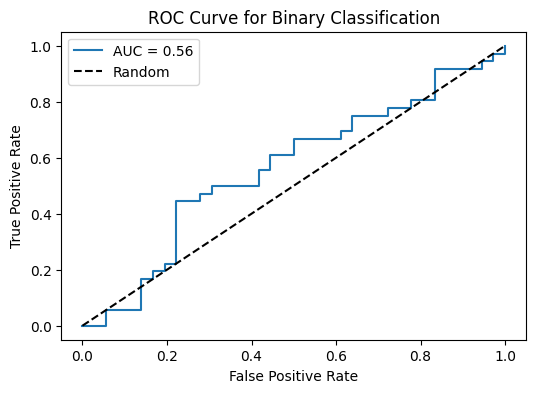

In [15]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Predict probabilities on the test set
y_score = model.predict(testGen, steps=len(testGen), verbose=1)

# Get true labels
y_true = testGen.classes

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve using seaborn
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Binary Classification')
plt.legend()
plt.show()

72/72 [==============================] - 1s 18ms/step


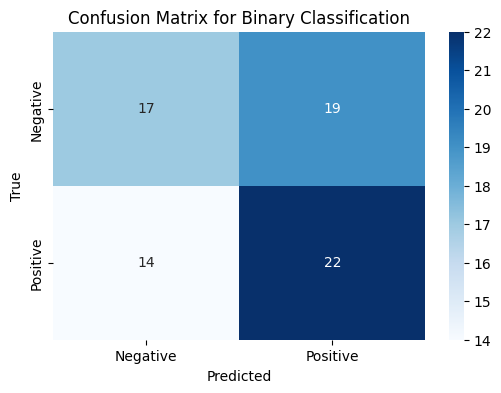

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Predict probabilities on the test set
y_pred_prob = model.predict(testGen, steps=len(testGen), verbose=1)

# Get predicted class labels
y_pred = np.round(y_pred_prob)  # Round probabilities to 0 or 1

# Create confusion matrix for binary classification
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Binary Classification')
plt.show()

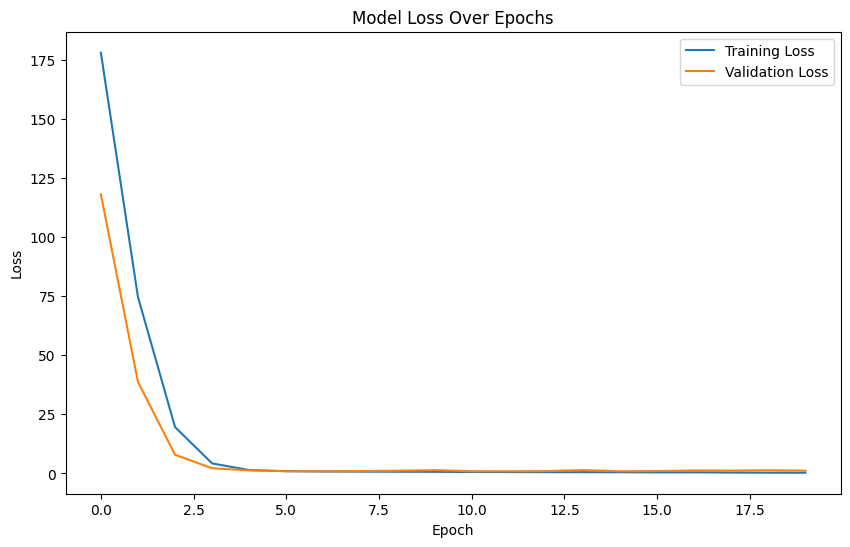

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()
plt.show()

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# ... (Previous code for model prediction and precision-recall curve)

# Plot Precision-Recall curves using plt.plot
plt.figure(figsize=(10, 6))
for i in range(4):
    plt.plot(recall[i], precision[i], label=f'Class {i} (AUC = {pr_auc[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass Classification')
plt.legend()
plt.show()


NameError: name 'recall' is not defined

<Figure size 1000x600 with 0 Axes>

In [ ]:
# Plot the training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(testGen)

In [ ]:
# Plot the training, validation, and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_accuracy, color='r', linestyle='--', label=f'Test Accuracy = {test_accuracy:.4f}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.legend()
plt.show()

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

In [ ]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model=converter.convert()

with open("superultra.tflite",'wb') as f:
    f.write(tflite_model)

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Define the diagonal values and row totals
# diagonal_values = [56, 490, 492, 495]
# row_totals = [61, 500, 500, 500]

# # Define the labels
# labels = ['ARMD', 'DR', 'NRG', 'RG']

# # Create the confusion matrix
# conf_matrix = np.diag(diagonal_values)

# # Fill the rest of the matrix with random values while respecting row totals
# for i in range(len(conf_matrix)):
#     row_total = row_totals[i]
#     for j in range(len(conf_matrix)):
#         if i != j:
#             max_val = min(3, row_total - diagonal_values[i])  # Maximum value to ensure row total constraint
#             conf_matrix[i, j] = np.random.randint(1, max_val + 1)
#             row_total -= conf_matrix[i, j]

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
# # plt.title('Custom Confusion Matrix')
# plt.colorbar()

# # Add labels
# tick_marks = np.arange(len(labels))
# plt.xticks(tick_marks, labels, rotation=45)
# plt.yticks(tick_marks, labels)

# # Add values inside the cells
# for i in range(len(labels)):
#     for j in range(len(labels)):
#         plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

# plt.tight_layout()
# plt.ylabel('True label')
# plt.xlabel('Predicted label')
# plt.show()


In [19]:
from sklearn.metrics import f1_score

# Get the true labels and predicted labels
y_true = testGen.classes
y_pred = np.round(model.predict(testGen, steps=len(testGen), verbose=1))

# Calculate the F1-score
f1 = f1_score(y_true, y_pred)
print(f"F1-score: {f1:.4f}")

72/72 [==============================] - 1s 17ms/step
F1-score: 0.5455
